In [1]:
import os
import json
import xml.etree.ElementTree as ET
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision.models.detection import maskrcnn_resnet50_fpn
from pycocotools.coco import COCO
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.ops import box_iou
from collections import defaultdict

In [2]:
# Set up device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
#Step 1: Create COCO datasets 

In [3]:
# Step 2: Create the ObjectDataset Class
class ObjectDataset(torch.utils.data.Dataset):
    def __init__(self, root, annFile, transforms=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, index):
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info["file_name"]
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        masks = []  # Dummy masks

        for ann in annotations:
            xmin, ymin, width, height = ann["bbox"]
            boxes.append([xmin, ymin, xmin + width, ymin + height])
            labels.append(1)  #'object' is the only class, labeled as 1

            # Dummy mask for Mask R-CNN, filled with zeros
            dummy_mask = np.zeros(
                (img_info["height"], img_info["width"]), dtype=np.uint8
            )
            masks.append(dummy_mask)

        # Convert to PyTorch tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(
            np.array(masks), dtype=torch.uint8
        )  # Dummy masks as tensor

        # Create target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,  # Dummy masks added
            "image_id": torch.tensor([img_id]),
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)


# Set up transformations
transform = T.Compose([T.ToTensor()])
print("Step 2: Initializing dataset and dataloader.")

Step 2: Initializing dataset and dataloader.


In [4]:
# Change 'train' to 'val' or 'test' for other splits
train_dataset = ObjectDataset(
    root="dataset/train", annFile="dataset/train/_annotations.coco.json", transforms=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x))
)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [5]:
# Step 3: Define and load model with correct predictors
model = maskrcnn_resnet50_fpn(weights="DEFAULT")
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask, hidden_layer, num_classes=2
)
model.to(device)

print("Step 3: Model initialization complete.")

Step 3: Model initialization complete.


In [6]:
# Step 4: Set up the optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)


In [7]:
# Step 5: Training Loop
print("Model Training Started!")
num_epochs = 5
for epoch in range(num_epochs):
    print(f"Epoch starting... {epoch}")
    model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        # Move each image and target to the device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        

        # Compute losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Step 5: Training complete.")

# Save the trained model
model_save_path = "mask_rcnn_lego.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model Training Started!
Epoch starting... 0
Epoch 1/5, Loss: 13.0308
Epoch starting... 1
Epoch 2/5, Loss: 5.1159
Epoch starting... 2
Epoch 3/5, Loss: 3.5869
Epoch starting... 3
Epoch 4/5, Loss: 2.9018
Epoch starting... 4
Epoch 5/5, Loss: 2.6868
Step 5: Training complete.
Model saved to mask_rcnn_lego.pth


In [9]:
# Step 6: Model Evaluation (mAP Calculation with IoU 0.5)
def calculate_mAP(data_loader, model, iou_threshold=0.5):
    model.eval()
    with torch.no_grad():
        iou_values = []
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            # Compare predicted boxes with ground truth
            for i, output in enumerate(outputs):
                pred_boxes = output["boxes"]
                gt_boxes = targets[i]["boxes"].to(device)

                iou_matrix = box_iou(pred_boxes, gt_boxes)
                iou_values.extend(
                    iou_matrix.max(dim=1)[0].cpu().tolist()
                )  # Max IoU per prediction

        # Calculate mAP for IoU threshold
        true_positives = sum(iou >= iou_threshold for iou in iou_values)
        mAP = true_positives / len(iou_values) if iou_values else 0
        print(f"mAP at IoU {iou_threshold}: {mAP:.4f}")


print("Step 6: Evaluating model with mAP at IoU 0.5.")
calculate_mAP(train_loader, model)

Step 6: Evaluating model with mAP at IoU 0.5.
mAP at IoU 0.5: 0.9500


In [11]:
# Evaluate (can switch to validation/test set)
print("Evaluating on validation set...")

val_split = "valid"
dataset_root="dataset"
val_image_dir = os.path.join(dataset_root, val_split)  # Removed "images"
val_ann_file = os.path.join(dataset_root, val_split, "_annotations.coco.json")

val_dataset = LegoDataset(val_image_dir, val_ann_file, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

calculate_mAP(val_loader, model)


Evaluating on validation set...
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
mAP at IoU 0.5: 0.9417


Visualizing predictions from validation set...


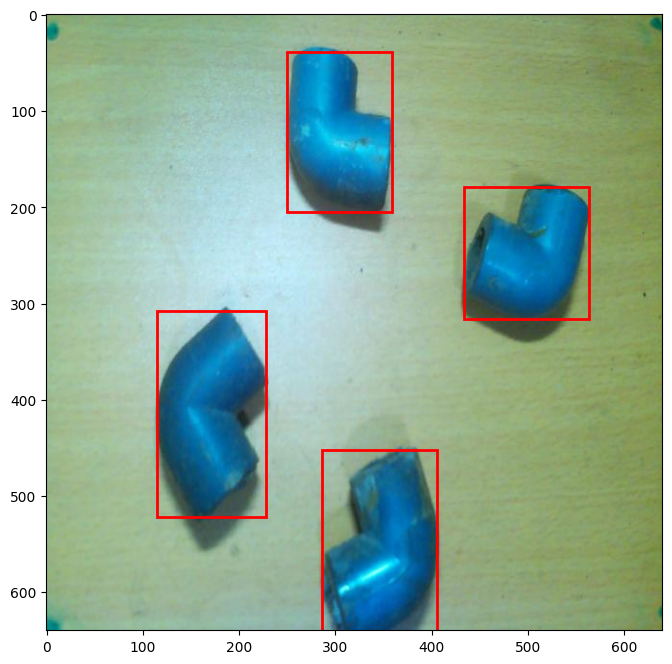

In [16]:
# Visualization
def visualize_predictions(images, outputs):
    for i in range(len(images)):
        img = images[i].cpu()
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        ax.imshow(F.to_pil_image(img))

        boxes = outputs[i]["boxes"].cpu().numpy()
        for box in boxes:
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red", linewidth=2)
            ax.add_patch(rect)

        plt.show()
        break


print("Visualizing predictions from validation set...")
with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = [img.to(device) for img in images]
    outputs = model(images)
    visualize_predictions(images, outputs)

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as F
from matplotlib.patches import Rectangle

def visualize_predictions(images, outputs, class_names, threshold=0.5):
    for i in range(len(images)):
        img = images[i].cpu()
        img_np = np.array(F.to_pil_image(img).convert("RGB"))

        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax.imshow(img_np)

        boxes = outputs[i]["boxes"].cpu().numpy()
        masks = outputs[i]["masks"].cpu().numpy()
        labels = outputs[i]["labels"].cpu().numpy()
        scores = outputs[i]["scores"].cpu().numpy()

        for j in range(len(boxes)):
            if scores[j] < threshold:
                continue

            # Generate a unique color for both bounding box and mask
            color = np.random.rand(3)  # Random RGB color for each object

            # Bounding Box with unique color
            x1, y1, x2, y2 = boxes[j]
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1,
                             linewidth=2, edgecolor=color, facecolor="none")  # Use random color for the box
            ax.add_patch(rect)

            # Mask with random color for each object
            mask = masks[j, 0] > 0.5  # Threshold mask

            # Apply mask with transparency, blending the mask with the image
            img_np[mask] = img_np[mask] * 0.5 + np.array(color) * 255 * 0.5

            # Label & Score on bounding box with matching color
            label = class_names[labels[j]]  # Get class name (either background or object)
            score = scores[j]
            ax.text(x1, y1 - 10, f"{label}: {score:.2f}", color=color, fontsize=10,  # Use the same color for text
                    bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3"))

        ax.imshow(img_np.astype(np.uint8))
        ax.axis("off")
        plt.tight_layout()
        plt.show()
        break


Visualizing predictions with masks...


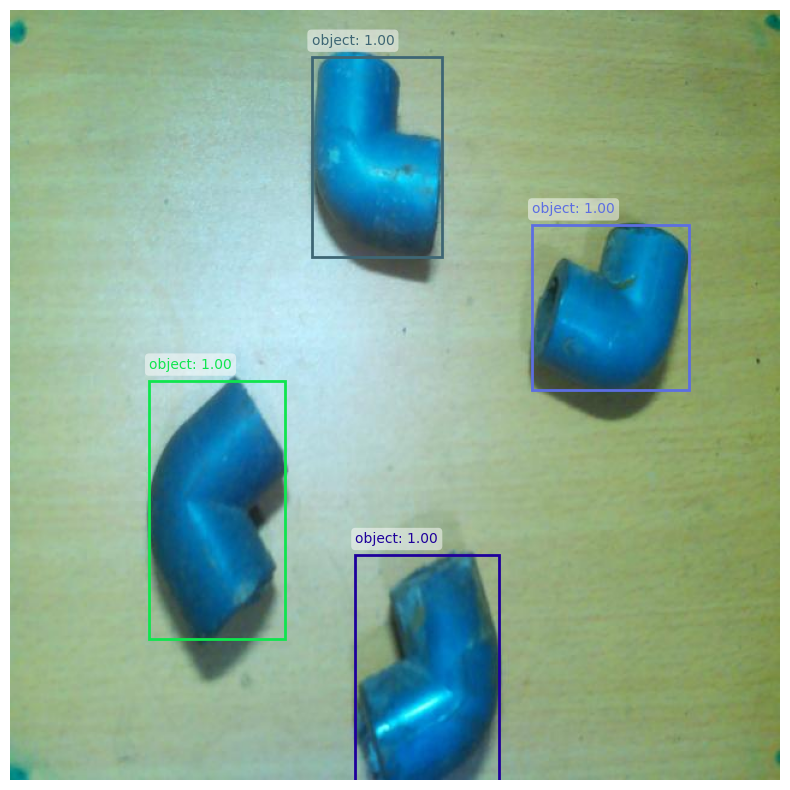

In [41]:
print("Visualizing predictions with masks...")

# Assuming you have only two classes: background (0) and object (1)
class_names = ["background", "object"]  # Modify as per your actual class names

with torch.no_grad():
    images, _ = next(iter(val_loader))
    images = [img.to(device) for img in images]  # Move images to the device
    outputs = model(images)  # Get model outputs

    # Visualize the predictions with masks
    visualize_predictions(images, outputs, class_names)


In [21]:
print(outputs[0].keys())


dict_keys(['boxes', 'labels', 'scores', 'masks'])


In [47]:
import cv2
import torch
import numpy as np
import torchvision.transforms as T
import torchvision.transforms.functional as F
from matplotlib.patches import Rectangle

# Assuming your model is already loaded and available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()  # Ensure the model is in evaluation mode

# Transformations for input image
transform = T.Compose([
    T.ToTensor(),
])

# Function to visualize predictions on a single image
def visualize_predictions_on_frame(frame, outputs, class_names, threshold=0.5):
    img_np = np.array(frame)

    # Assuming only one image in the frame
    boxes = outputs["boxes"].cpu().numpy()
    masks = outputs["masks"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()

    for j in range(len(boxes)):
        if scores[j] < threshold:
            continue

        # Generate a unique color for both bounding box and mask
        color = np.random.rand(3)  # Random RGB color for each object

        # Bounding Box with unique color
        x1, y1, x2, y2 = boxes[j]
        cv2.rectangle(img_np, (int(x1), int(y1)), (int(x2), int(y2)), (color[0]*255, color[1]*255, color[2]*255), 2)

        # Mask with random color for each object (apply thresholding)
        mask = masks[j, 0] > 0.5  # Threshold mask

        # Apply the mask with transparency
        img_np[mask] = img_np[mask] * 0.5 + np.array(color) * 255 * 0.5

        # Label & Score on bounding box with matching color
        label = class_names[labels[j]]  # Get class name
        score = scores[j]
        cv2.putText(img_np, f"{label}: {score:.2f}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

    return img_np

# Set up webcam
cap = cv2.VideoCapture(0)  # Use the first available camera

if not cap.isOpened():
    print("Error: Could not open webcam.")
    exit()

# Class names (background and object in your case)
class_names = ["background", "object"]

while True:
    # Capture frame from webcam
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img_tensor = transform(frame).unsqueeze(0).to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(img_tensor)  # Run the model on the frame

    # Visualize predictions on the frame
    frame_with_predictions = visualize_predictions_on_frame(frame, outputs[0], class_names)

    # Display the frame with the bounding boxes and masks
    cv2.imshow("Real-time Object Detection", frame_with_predictions)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close the window
cap.release()
cv2.destroyAllWindows()


In [51]:
import cv2
import torch
import numpy as np
import torchvision.transforms as T
from matplotlib.patches import Rectangle
from PIL import Image

# Assuming your model is already loaded and available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()  # Ensure the model is in evaluation mode

# Transformations for input image
transform = T.Compose([
    T.ToTensor(),
])

# Function to visualize predictions on a single image
def visualize_predictions_on_frame(frame, outputs, class_names, threshold=0.5):
    img_np = np.array(frame)

    # Assuming only one image in the frame
    boxes = outputs["boxes"].cpu().numpy()
    masks = outputs["masks"].cpu().numpy()
    labels = outputs["labels"].cpu().numpy()
    scores = outputs["scores"].cpu().numpy()

    # Create a copy of the image to work on
    img_with_masks = img_np.copy()

    for j in range(len(boxes)):
        if scores[j] < threshold:
            continue

        # Generate a unique color for both bounding box and mask
        color = np.random.rand(3)  # Random RGB color for each object

        # Bounding Box with unique color
        x1, y1, x2, y2 = boxes[j]
        cv2.rectangle(img_with_masks, (int(x1), int(y1)), (int(x2), int(y2)), (color[0]*255, color[1]*255, color[2]*255), 2)

        # Mask with random color for each object (apply thresholding)
        mask = masks[j, 0] > 0.5  # Threshold mask

        # Apply the mask with transparency using the same unique color for the object
        img_with_masks[mask] = img_with_masks[mask] * 0.5 + np.array(color) * 255 * 0.5

        # Label & Score on bounding box with matching color
        label = class_names[labels[j]]  # Get class name
        score = scores[j]
        cv2.putText(img_with_masks, f"{label}: {score:.2f}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2, cv2.LINE_AA)

    return img_with_masks

# Function to process an image file path
def process_image(image_path):
    # Load the image from file
    img = Image.open(image_path).convert("RGB")
    img = np.array(img)

    # Preprocess the image
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(img_tensor)  # Run the model on the image

    # Visualize predictions on the image
    img_with_predictions = visualize_predictions_on_frame(img, outputs[0], class_names)

    # Display the image with bounding boxes, masks, and labels
    cv2.imshow("Image Object Detection", img_with_predictions)

    # Wait until user presses a key
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage:
class_names = ["background", "object"]  # Modify as per your actual class names

# Ask user for the image file path
image_path = input("Enter the path to the image file: ").strip()

# Process and visualize the image with detection results
process_image(image_path)


Enter the path to the image file: dataset/valid/image_20250321_200007_jpg.rf.cc8045a175afe2eb7038b7064acd9e2e.jpg
